In [1]:
import pickle as pkl
import numpy as np
import pandas as pd

try:
    df  = pd.read_csv("counts_df.csv")
    df0 = pd.read_csv("counts_df_baseline.csv")
except IOError:
    
    print "IOError"

    with open("test_know_dist_T5.0_beta0.05.pkl","rb") as f:
        tst, tst_n_boxes, tst_scores = pkl.load(f)

    tst = tst.astype(float)

    df = pd.DataFrame({
        'counts':tst,
        'log_counts':np.log(1+tst),
        'n_boxes':tst_n_boxes,
        'pixels_above':tst_scores,
    })

    df.to_csv("counts_df.csv", index=False)
    
    with open("test_baseline.pkl","rb") as f:
        tst_base, tst_n_boxes_base, tst_scores_base = pkl.load(f)

    tst_base = tst_base.astype(float)

    df0 = pd.DataFrame({
        'counts':tst_base,
        'log_counts':np.log(1+tst_base),
        'n_boxes':tst_n_boxes_base,
        'pixels_above':tst_scores_base,
    })

    df0.to_csv("counts_df_baseline.csv", index=False)

In [2]:
df.head(10)

,counts,log_counts,n_boxes,pixels_above
0,1.0,0.693147,0,0.0
1,2.0,1.098612,2,1459.0
2,5.0,1.791759,6,6878.0
3,1.0,0.693147,6,2382.0
4,1.0,0.693147,6,5811.0
5,6.0,1.945910,6,7385.0
6,2.0,1.098612,6,6595.0
7,2.0,1.098612,2,1056.0
8,1.0,0.693147,4,2366.0
9,1.0,0.693147,4,2225.0


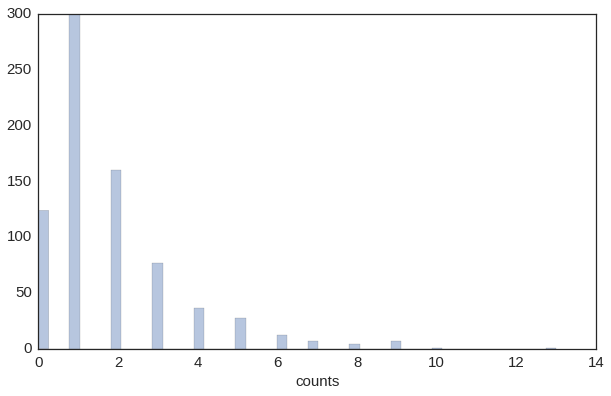

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set_style("white")

plt.rcParams['figure.figsize'] = (10, 6)

plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['axes.labelsize']  = 15

ax = sns.distplot(df.counts, kde=False)


To test how well the model performes while counting the number of people in an image we test the model a total of one thousand times. In each of these iterations we split the data-set in half (a training and a testing half) and train a gradient boosting regressor based with a simple linear model as its base learner.

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import precision_recall_fscore_support
from xgboost import XGBRegressor as XGB

for dframe in [df0, df]:
    
    table = pd.DataFrame(
        columns=["Precision", "Recall", "F1 score"],
    )
    
    r2, f1, pre, rec, = np.empty(shape=(0,7)), np.empty(shape=(0,7)), np.empty(shape=(0,7)), np.empty(shape=(0,7))
    for _ in range(1000):

        reg  = XGB(
            max_depth=1,
            learning_rate=0.3,
            n_estimators=35
        )

        X_trn, X_tst, y_trn, y_tst = train_test_split(
            dframe[['n_boxes','pixels_above']],
            dframe.log_counts,
            test_size=0.5,
        )

        reg.fit(X_trn, y_trn)

        y_true, y_pred = np.exp(y_tst), np.exp(reg.predict(X_tst))

        _r2 = r2_score(y_true, y_pred)

        precision, recall, f_score, _ = precision_recall_fscore_support(
            y_true.astype(int),
            np.round(y_pred).astype(int),
        )
        
        pre = np.concatenate((
            pre,
            precision[:7, np.newaxis].T
        ), axis=0)
        
        rec = np.concatenate((
            rec,
            recall[:7, np.newaxis].T
        ), axis=0)
        
        f1 = np.concatenate((
            f1,
            f_score[:7, np.newaxis].T
        ), axis=0)

    print "R2 Score: ", np.mean(_r2)
    
    table["Precision"] = np.mean(pre, axis=0)
    table["Recall"] = np.mean(rec, axis=0)
    table["F1 score"] = np.mean(f1, axis=0)
    
    print table.round(2).to_latex()

R2 Score:  0.44564769245
\begin{tabular}{lrrr}
\toprule
{} &  Precision &  Recall &  F1 score \\
\midrule
0 &       0.76 &    0.49 &      0.59 \\
1 &       0.52 &    0.66 &      0.58 \\
2 &       0.28 &    0.31 &      0.28 \\
3 &       0.28 &    0.13 &      0.17 \\
4 &       0.01 &    0.01 &      0.01 \\
5 &       0.09 &    0.09 &      0.08 \\
6 &       0.01 &    0.01 &      0.01 \\
\bottomrule
\end{tabular}

R2 Score:  0.609932509108
\begin{tabular}{lrrr}
\toprule
{} &  Precision &  Recall &  F1 score \\
\midrule
0 &       0.74 &    0.48 &      0.58 \\
1 &       0.56 &    0.73 &      0.64 \\
2 &       0.36 &    0.41 &      0.38 \\
3 &       0.32 &    0.11 &      0.15 \\
4 &       0.09 &    0.14 &      0.11 \\
5 &       0.23 &    0.23 &      0.21 \\
6 &       0.03 &    0.04 &      0.03 \\
\bottomrule
\end{tabular}

